
# PART III - Model selection and model recovery

**In this tutorial, we will see how to:**

- perform model selection using parametric and non-parametric methods (cross-validation)
- run model recovery analysis


In [2]:
# define the github path and authorization token
RAW_GITHUB_PATH = 'https://raw.githubusercontent.com/bambschool/BAMB2024/main/1-modeling_101/'

# define the list of files to be downloaded
files = ['tutorial_1_lib.py']

for file in files:
  !wget -O {file} "{RAW_GITHUB_PATH}{file}"

--2024-09-20 13:14:13--  https://raw.githubusercontent.com/bambschool/BAMB2024/main/1-modeling_101/tutorial_1_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4696 (4.6K) [text/plain]
Saving to: ‘tutorial_1_lib.py’

tutorial_1_lib.py   100%[===================>]   4.59K  --.-KB/s    in 0s      

2024-09-20 13:14:13 (38.4 MB/s) - ‘tutorial_1_lib.py’ saved [4696/4696]



In [3]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import pearsonr
import scipy.optimize as optimize

from tutorial_1_lib import *

**We use model B to generate fake data and in the following we assume that this is our actual experimental data.**

In [4]:
# Define stimulus values for the simulation
stim_values = [-3, -2, -1, -.5, 0, .5, 1, 2, 3]  # Possible stimulus evidence values

# Simulate Model B data, which we'll assume is our experimental data
n = 2500  # Number of trials
sigma = 1  # Decision noise parameter for Model B
Lambda = 0.2  # Proportion of lapses (Model B parameter)

# First, generate random experimental conditions and stimulus evidence for each trial
c = np.random.choice(a=['control', 'manipulation'], size=n)  # Condition
s = np.random.choice(a=stim_values, size=n)  # Stimulus evidence

# Simulate responses using Model B with the given parameters
r = simulate_modelB(s, c, sigma_d=sigma, Lambda=Lambda)

# Create a DataFrame to store the simulated data
data = pd.DataFrame({'stimulus': s, 'condition': c, 'response': r})

# III.1. Model selection

## Penalized log-likelihood (AIC, BIC)

To make the comparison more fair between models of different complexities, one approach is simply to apply a certain penalty term on top of the likelihood that penalizes the models with more parameters. The two most popular metrics for doing so just differ in the strength of the penalty term:
- the **Akaike Information Criterion (AIC)** is computed as $AIC = 2k - 2 \hat{LLH}$, where $k$ is the number of parameters of the model (i.e. a simple linear regression model will have two, the intercept and the slope) and $\hat{LLH}$ is the log-likelihood of the model estimated at the maximum-likelihood parameters (the value that is provided in the summary of the model after fitting).
- the **Bayesian Information Criterion (BIC)** is computed as $BIC = k \log n - 2 \hat{LLH}$ where $n$ is the number of observations (i.e. trials).
The smaller the AIC (or BIC), the better is the model, because of the negative sign before the log-likelihood. The first part of the equation is positive and correspond to the penalty term. That term is larger in the case of the BIC, i.e. the BIC penalizes more severely models with many parameters than the AIC. In other words, it will be more conservative in rejecting the null hypothesis. It's important to note that these are **relative measures**: their raw values tell us very little, it's only by comparing values between different models that we can interpret which model better captures the data. So we cannot conclude from the BIC/AIC that one model is a good model of the data; only that it is a better model of the data than others.

Akaike's rule of thumb: **two models are essentially indistinguishable if the difference of their AICs is less than 2** (same for BIC). The larger the difference, the more evidence towards the better model against the other.


**Follow the example of `fit_model0` to define functions that fit model A and B and return the fitted parameters, the log-likelihood, AIC and BIC.**

In [5]:
# - Using Penalized Log-Likelihood (AIC, BIC) to select the best model
# Define functions to fit each model and compute AIC and BIC

def fit_model0(data):
    """
    Fit the null model (Model B with Lambda=0) and compute the AIC, BIC.
    """
    # Minimize the negative log-likelihood of Model B with Lambda=0
    result = optimize.minimize(lambda pp: -LogLikelihood_modelB(data, pp[0], 0), x0=[1], bounds=[(0.1, 10)])

    # Extract fitted parameters and log-likelihood
    LLH = -result.fun  # Log-likelihood
    AIC = 2 * len(result.x) - 2 * LLH  # AIC calculation
    BIC = len(result.x) * np.log(data.shape[0]) - 2 * LLH  # BIC calculation

    return result.x, LLH, AIC, BIC

def fit_modelA(data):
    """
    Fit Model A and compute AIC and BIC.
    """
    # Minimize the negative log-likelihood for Model A (with parameters sigma_d, sigma_m)
    result = optimize.minimize(lambda pp: -LogLikelihood_modelA(data, pp[0], pp[1]), x0=[1, 1], bounds=[(0.1, 10), (0.1, 10)])

    # Extract fitted parameters and log-likelihood
    LLH = -result.fun
    AIC = 2 * len(result.x) - 2 * LLH  # AIC calculation
    BIC = len(result.x) * np.log(data.shape[0]) - 2 * LLH  # BIC calculation

    return result.x, LLH, AIC, BIC

def fit_modelB(data):
    """
    Fit Model B and compute AIC and BIC.
    """
    # Minimize the negative log-likelihood for Model B (with parameters sigma_d, Lambda)
    result = optimize.minimize(lambda pp: -LogLikelihood_modelB(data, pp[0], pp[1]), x0=[1, 0.1], bounds=[(0.1, 10), (0, 1)])

    # Extract fitted parameters and log-likelihood
    LLH = -result.fun
    AIC = 2 * len(result.x) - 2 * LLH  # AIC calculation
    BIC = len(result.x) * np.log(data.shape[0]) - 2 * LLH  # BIC calculation

    return result.x, LLH, AIC, BIC

# Example usage: fit models to the data
model0_x, model0_LLH, model0_AIC, model0_BIC = fit_model0(data)  # Null model
modelA_x, modelA_LLH, modelA_AIC, modelA_BIC = fit_modelA(data)  # Model A
modelB_x, modelB_LLH, modelB_AIC, modelB_BIC = fit_modelB(data)  # Model B

**Visualize the AIC and BIC of model A and B vs. the null model (e.g. in a bar plot). What do you conclude?**

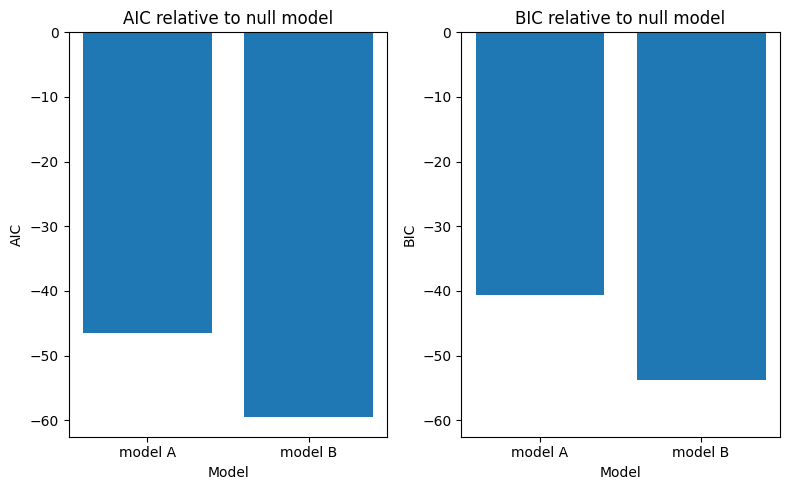

In [6]:
# Visualize AIC and BIC differences between models
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Plot AIC difference relative to the null model
axes[0].bar(['model A', 'model B'], [modelA_AIC - model0_AIC, modelB_AIC - model0_AIC])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('AIC')
axes[0].set_title('AIC relative to null model')

# Plot BIC difference relative to the null model
axes[1].bar(['model A', 'model B'], [modelA_BIC - model0_BIC, modelB_BIC - model0_BIC])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('BIC')
axes[1].set_title('BIC relative to null model')

# Ensure both plots have the same y-axis range
min_val = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
max_val = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(min_val, max_val)
axes[1].set_ylim(min_val, max_val)

plt.tight_layout()
plt.show()

Both model A and model B have smaller AIC and BIC than the null model. Model B has the smallest AIC and BIC and thus, based on both measures, we conclude that the data favors model B.

## Cross-validation

The AIC and BIC are convenient because they are easy to compute, but they are just "approximately good". For large sample size, they work well, but for smaller sample size they may not accurately describe which model is better.

Another approach for comparing models on experimental data while adjusting for model complexity is to test the model performance on datapoints that have not been used to train/fit the model (i.e. estimated the maximum-likelihood parameters). If a model with many parameters is overfitting, i.e. its parameters are adjusted to predict very well the datapoints it was trained on (it is fitting 'noise'), then its performance may decrease severely when testing the model with the same parameters but on a new dataset.

How this is done in practice is using **cross-validation**, where the dataset is chunked in pieces (or folds), where each piece alternatively takes the role of the training and test dataset. The most standard form of cross-validation is K-fold cross-validation, where K describes the number of folds in which the data is split. The log-likelihood of cross-validated data is described as "Cross-Validated Log-Likelihood" (**CVLL**).

In general, the larger is K, the more robust your measure is. The extreme case is **leave-one-out cross-validation** (LOOCV) where basically you split the datasets in sets of just one observation (trials); then on each fold you fit all your dataset on all the dataset but one observation and test it on this single heldout observation. So LOOCV is like K-fold CV where K equals the number of observations. However, by increasing K, you also increase the computational complexity as you need to fit the model over and over, so things can get slow.

Cross-validation is a robust method for choosing the best statistical model for a certain dataset. It does not suffer the same limitations as AIC/BIC, and can be used for other metrics than the log-likelihood such as the mean squared error or the classification accuracy. This it can be used also for complex methods when the likelihood cannot be evaluated.
This is why **cross-validation is the standard method in machine learning** to compare the performance of any type of models (deep networks, auto-encoders, SVMs, etc.).



In this code, we split the data into 10 subsets using `Kfold` (from `sklearn.model_selection`). `KFold` handles cross-validation subset splitting and train/test assignment.  In particular, the `Kfold.split` method returns an iterator which we can loop through. On each loop, this iterator assigns a different subset as validation and returns new training and validation indices with which to split the data.

**We will loop through the 10 train/validation splits and on each split compute the log-likelihood of both models on the test set. Then we will average the CVLL over splits.**

In [7]:
# Perform K-fold cross-validation to compute Cross-Validated Log-Likelihood (CVLL)
from sklearn.model_selection import KFold

# Number of folds for cross-validation
K = 10
kf = KFold(n_splits=K)

**Apply K-fold validation on the dataset to compute the CVLL for the null model and model A and B.**

In [8]:
# Initialize arrays to store Cross-Validated Log-Likelihoods (CVLL) for each model
model0_CVLL = np.empty((0))
modelA_CVLL = np.empty((0))
modelB_CVLL = np.empty((0))

# Perform K-fold cross-validation
for i, (train_index, test_index) in enumerate(kf.split(data)):
    df_train = data.iloc[train_index]  # Training data
    df_test = data.iloc[test_index]  # Test data

    # Fit and compute CVLL for the null model
    pp, _, _, _ = fit_model0(df_train)
    model0_CVLL = np.append(model0_CVLL, LogLikelihood_modelB(df_test, pp[0], 0))

    # Fit and compute CVLL for Model A
    ppA, _, _, _ = fit_modelA(df_train)
    modelA_CVLL = np.append(modelA_CVLL, LogLikelihood_modelA(df_test, ppA[0], ppA[1]))

    # Fit and compute CVLL for Model B
    ppB, _, _, _ = fit_modelB(df_train)
    modelB_CVLL = np.append(modelB_CVLL, LogLikelihood_modelB(df_test, ppB[0], ppB[1]))

# Compute average CVLL across all folds for each model
model0_avg_CVLL = np.mean(model0_CVLL)
modelA_avg_CVLL = np.mean(modelA_CVLL)
modelB_avg_CVLL = np.mean(modelB_CVLL)

**Show the results obtained for the CVLL.** What do you conclude?

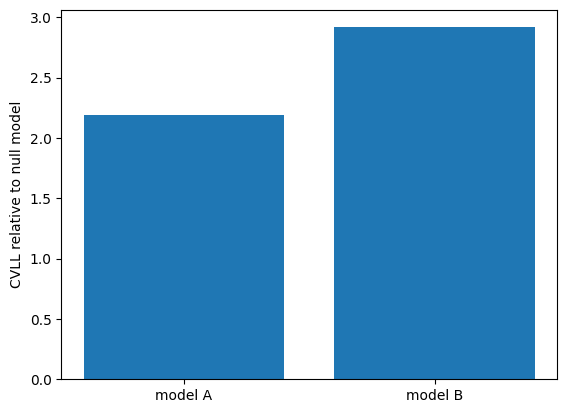

In [9]:
# Visualize the CVLL results
plt.bar(['model A', 'model B'], [modelA_avg_CVLL - model0_avg_CVLL, modelB_avg_CVLL - model0_avg_CVLL])
plt.ylabel('CVLL relative to null model')
plt.show()

Model B has the highest cross-validated likelihood, though the difference between model A and B is rather small.

# III.2. Model recovery

To illustrate model recovery, here we will simulate behavior of three models: the null model, model A and model B.

For each simulation, model parameters should be sampled randomly for each model.

Each simulated data set will then be fit to each of the given models, to determine which model fit best (according to BIC). This process will be repeated 100 times (number of "repetitions" or "counts") to compute the confusion matrix.

## Confusion matrix

Let's build a confusion matrix. It quantifies the probability that each model is the best fit to data generated from the other models. In a perfect world the confusion matrix will be the identity matrix, but in practice this is not always the case.

How to read the confusion matrix? Given a winning model (a particular column), it tells you the likelihood of each ground-truth model (each row) to have generated the data (basically, the columns are more important than the rows).

As pointed out in the lecture, it is crucial to choose the simulation parameters in the range of the fitted parameters. This is easy in this exercise because we know the true parameters. In practise we need to rely on our prior knowledge.

**Complete the following code.**

In [10]:
# Define a list of fitting functions for the three models
fitting_functions = [fit_model0, fit_modelA, fit_modelB]

# Initialize the confusion matrix (3x3 for our 3 models)
confusion_matrix = np.zeros((len(fitting_functions), len(fitting_functions)))

# Define the number of repetitions for simulation and model fitting
Ncounts = 100  # Increase to 100 for more accuracy

for i in range(Ncounts):
    # Simulate data for Model 0 (null model) with sigma=1, Lambda=0
    r_sim = simulate_modelB(s, c, sigma_d=1, Lambda=0)
    data_sim = pd.DataFrame({'stimulus': s, 'condition': c, 'response': r_sim})

    # Fit the simulated data using all models and record the best-fitting model
    LLHs = []
    for fit_function in fitting_functions:
        _, LLH, _, _ = fit_function(data_sim)
        LLHs.append(LLH)

    # Update confusion matrix (simulated with Model 0, fitted with best model)
    confusion_matrix[0, np.argmax(LLHs)] += 1

    # Repeat the process for Model A (simulate and fit)
    r_sim = simulate_modelA(s, c, sigma_d=1, sigma_m=0.5)
    data_sim = pd.DataFrame({'stimulus': s, 'condition': c, 'response': r_sim})
    LLHs = []
    for fit_function in fitting_functions:
        _, LLH, _, _ = fit_function(data_sim)
        LLHs.append(LLH)
    confusion_matrix[1, np.argmax(LLHs)] += 1

    # Repeat the process for Model B (simulate and fit)
    r_sim = simulate_modelB(s, c, sigma_d=1, Lambda=0.2)
    data_sim = pd.DataFrame({'stimulus': s, 'condition': c, 'response': r_sim})
    LLHs = []
    for fit_function in fitting_functions:
        _, LLH, _, _ = fit_function(data_sim)
        LLHs.append(LLH)
    confusion_matrix[2, np.argmax(LLHs)] += 1

**Now, we normalize the confusion matrix and visualize it.**

[[0.   0.81 0.19]
 [0.   1.   0.  ]
 [0.   0.03 0.97]]


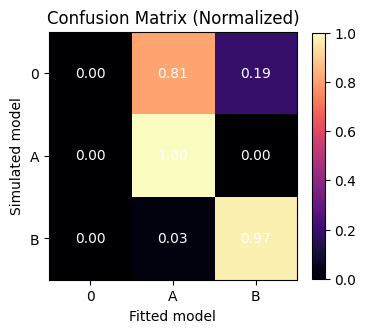

In [12]:
# Normalize confusion matrix
confusion_matrix_norm = np.array([row/Ncounts for row in confusion_matrix])

# Plot and print the normalized confusion matrix
print(confusion_matrix_norm)

plt.figure(figsize=(4,4))
plt.imshow(confusion_matrix_norm, vmin=0, vmax=1, cmap='magma')
plt.colorbar(shrink=0.8)

# Add text annotations for each square
for i in range(confusion_matrix_norm.shape[0]):
    for j in range(confusion_matrix_norm.shape[1]):
        plt.text(j, i, f"{confusion_matrix_norm[i, j]:.2f}", ha="center", va="center", color="white")

plt.xlabel('Fitted model')
plt.ylabel('Simulated model')
plt.xticks([0, 1, 2], ["0", "A", "B"])
plt.yticks([0, 1, 2], ["0", "A", "B"])
plt.title("Confusion Matrix (Normalized)")
plt.show()


- Does your confusion matrix have large off-diagonal components? If so, this indicates that you have a problem with model recovery.

- How do changes in the generating parameters affect the confusion matrix?

You can observe that the confusion matrix can be so dependent on the simulating parameter values means that it is crucial to match the simulation parameters to the actual fit parameters of your actual behavioral data (when you have some) as best as possible. Models that are identifiable in one parameter regime may be impossible to distinguish in another regime.

A final note to remember: As with all model comparisons, it only tells you which model fits best of the models you considered. In and of itself, this is rather limited information as there are infinitely many other models that you did not consider. This makes it imperative to start with a good set of models initially, that rigorously capture the competing hypotheses.

## Inversion matrix

Can you arbitrate between different models? The inversion matrix is usful for this purpose. It is defined as
$p(simulated model | fit model)$, the probability that data best fit by one model were actually
generated from another model. This can be readily computed from the
confusion matrix, $p(fit model | simulated model)$, by Bayes rule.

For a uniform prior on models, computing the inversion matrix amounts to renormalizing
the confusion matrix over the simulated models.


[[0.   0.81 0.19]
 [0.   1.   0.  ]
 [0.   0.03 0.97]]


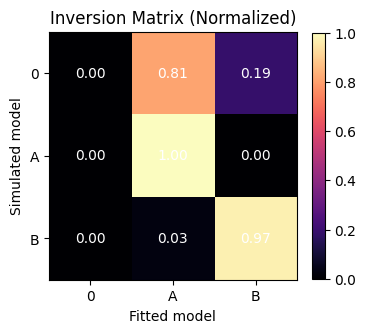

In [13]:
# Compute inversion matrix by normalizing the confusion matrix over simulated models (rows)
inversion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

# Plot and print the inversion matrix
print(inversion_matrix)

plt.figure(figsize=(4,4))
plt.imshow(inversion_matrix, vmin=0, vmax=1, cmap='magma')
plt.colorbar(shrink=0.8)

# Add text annotations for each square
for i in range(inversion_matrix.shape[0]):
    for j in range(inversion_matrix.shape[1]):
        plt.text(j, i, f"{inversion_matrix[i, j]:.2f}", ha="center", va="center", color="white")

plt.xlabel('Fitted model')
plt.ylabel('Simulated model')
plt.xticks([0, 1, 2], ["0", "A", "B"])
plt.yticks([0, 1, 2], ["0", "A", "B"])
plt.title("Inversion Matrix (Normalized)")
plt.show()
